In [1]:
from models.mc import hybridMonteCarlo
from models.pso import PSO_Numpy, PSO_OpenCL_hybrid, PSO_OpenCL_scalar, PSO_OpenCL_vec
from models.utils import checkOpenCL
from models.utils import openCLEnv
import pyopencl as cl

import numpy as np
import matplotlib.pyplot as plt
import time

### fitness function: pso American option

In [2]:
def measureFitness(min_exp, max_exp, step, S0, r, sigma, T, nPath, nPeriod, K, opttype):
    cl_hy_time = []
    cl_sc_time = []
    cl_vec_time = []
    np_time = []
    fish_size = []

    print(f'{nPath} paths, {nPeriod} periods.\n')
    
    for exponent in range(min_exp, max_exp, step):  # This bit shift << operation does 'two to the exponent' (2^exponent)
        nFish = 1 << exponent            # 相当于 2 ** max_exp
        fish_size.append(nFish)
        print("exponent @ %s with nFish set to %d" %(exponent, nFish))

        mc = hybridMonteCarlo(S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish)
        pso_np = PSO_Numpy(mc, nFish)
        pso_hy = PSO_OpenCL_hybrid(mc, nFish)
        pso_sc = PSO_OpenCL_scalar(mc, nFish)
        pso_vec = PSO_OpenCL_vec(mc, nFish, vec_size=8)
        # initialize data & memory objects
        pso = np.random.uniform(size=(nPeriod, nFish)).astype(np.float32) * 100.0
        
        # -------> run kernel - pso hybrid
        ts = time.perf_counter() 
        pso_hy._costPsoAmerOption_cl()
        openCLEnv.queue.finish()        
        walltime = (time.perf_counter() - ts)*1e3
        cl_hy_time.append(round(walltime, 4))
        print('>>> hybrid GPU time: %s ms' %(cl_hy_time[-1]))

        # -------> run kernel - pso scalar
        ts = time.perf_counter() 
        pso_sc._costPsoAmerOption_cl()
        openCLEnv.queue.finish()        
        walltime = (time.perf_counter() - ts)*1e3
        cl_sc_time.append(round(walltime, 4))
        print('>>> scalar GPU time: %s ms' %(cl_sc_time[-1]))

        # -------> run kernel - pso scalar
        ts = time.perf_counter() 
        pso_vec._costPsoAmerOption_cl()
        openCLEnv.queue.finish()        
        walltime = (time.perf_counter() - ts)*1e3
        cl_vec_time.append(round(walltime, 4))
        print('>>> vectorzied GPU time: %s ms' %(cl_vec_time[-1]))
        
        # -------> run benchmark
        ts = time.perf_counter()
        fitFunc = np.vectorize(pso_np._costPsoAmerOption_np, signature='(n)->()')
        costs_valid = fitFunc(pso.T).astype(np.float32)
        numpytime = (time.perf_counter() - ts)*1e3
        np_time.append(round(numpytime, 4))
        print('>>> numpy CPU time: %s ms' %(np_time[-1]))
        
        # cleanup device memory
        mc.cleanUp()
    
    return cl_hy_time, cl_sc_time, cl_vec_time, np_time, fish_size

### searchGrid: particle move

In [3]:
def measureMoveParticle(min_exp, max_exp, step, S0, r, sigma, T, nPath, nPeriod, K, opttype):    
    cl_hy_time = []
    cl_sc_time = []
    cl_vec_time = []
    np_time = []
    fish_size = []
    
    print(f'PSO with {nPeriod} particle dimensions.\n')
    
    for exponent in range(min_exp, max_exp, step):  # This bit shift << operation does 'two to the exponent' (2^exponent)
        nFish = 1 << exponent            # 相当于 2 ** max_exp
        fish_size.append(nFish)
        print("exponent @ %s with nFish set to %d" %(exponent, nFish))
        
        mc = hybridMonteCarlo(S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish)
        pso_np = PSO_Numpy(mc, nFish)
        pso_hy = PSO_OpenCL_hybrid(mc, nFish)
        pso_sc = PSO_OpenCL_scalar(mc, nFish)
        pso_vec = PSO_OpenCL_vec(mc, nFish, vec_size=8)
        
        # ----> run kernel - PSO hybrid
        ts = time.perf_counter()
        pso_hy._searchGrid()
        openCLEnv.queue.finish()
        walltime = (time.perf_counter() - ts)*1e3
        cl_hy_time.append(round(walltime, 4))
        print('>>> hybrid GPU time: %s ms' %(cl_hy_time[-1]))

        # ----> run kernel - PSO scalar
        ts = time.perf_counter()
        pso_sc._searchGrid()
        openCLEnv.queue.finish()
        walltime = (time.perf_counter() - ts)*1e3
        cl_sc_time.append(round(walltime, 4))
        print('>>> scalar GPU time: %s ms' %(cl_sc_time[-1]))

        # ----> run kernel - PSO vectorzied
        ts = time.perf_counter()
        pso_vec._searchGrid()
        openCLEnv.queue.finish()
        walltime = (time.perf_counter() - ts)*1e3
        cl_vec_time.append(round(walltime, 4))
        print('>>> vectorzied GPU time: %s ms' %(cl_vec_time[-1]))
        
        # ----> run benchmark
        ts = time.perf_counter()
        pso_np._searchGrid()
        numpytime = (time.perf_counter() - ts)*1e3
        np_time.append(round(numpytime, 4))
        print('>>> numpy CPU time: %s ms' %(np_time[-1]))

        # cleanup device memory
        pso_hy.cleanUp()
        pso_sc.cleanUp()
        pso_vec.cleanUp()
        mc.cleanUp()    

    return cl_hy_time, cl_sc_time, cl_vec_time, np_time, fish_size


In [4]:
# def plotResults(min_exp, max_exp, step, S0, r, sigma, T, nPath, nPeriod, K, opttype, measureFunc):
#     cl_hy_time, cl_sc_time, cl_vec_time, np_time, fish_size =  measureFunc(min_exp, max_exp, step, S0, r, sigma, T, nPath, nPeriod, K, opttype)

#     nfish = np.array(fish_size)
#     x = np.arange(min_exp, max_exp, step, dtype=int)
#     xtick = np.array([2**i for i in x])
#     fig = plt.figure(figsize=(12,5))
#     plt.plot(x, np.array(cl_hy_time), 'y-.', label='knl_hybrid_time')
#     plt.plot(x, np.array(cl_sc_time), 'g-.', label='knl_scalar_time')
#     if len(cl_vec_time) == len(cl_hy_time):
#         plt.plot(x, np.array(cl_vec_time), 'r-.', label='knl_vec_time')
#     plt.plot(x, np.array(np_time), 'b', label='numpy_time')

#     print('fish size:', nfish)
#     if len(cl_vec_time) == len(cl_hy_time):
#         print('knl_vec_time ms:   ', cl_vec_time)
#     print('knl_scalar_time ms:', cl_sc_time)
#     print('knl_hybrid_time ms:', cl_hy_time)
#     print('numpy runtime ms:  ', np_time)
#     print('GPU multiples np/cl_vec:  ', np.array(np_time)/np.array(cl_vec_time))
    
#     plt.legend(loc='best')
#     plt.ylabel('milli-second (ms)')
#     plt.xlabel('fish size (2^n) ranging from %d to %d'%( min(nfish), max(nfish) ) )
#     plt.xticks(x, xtick)
#     plt.title(f'PSO {measureFunc}: kernel (dotted) vs. numpy (solid) with {nPeriod} periods {nPath} paths')
#     plt.show()

In [5]:
def plotResults(min_exp, max_exp, step, S0, r, sigma, T, nPath, nPeriod, K, opttype, measureFunc):
    cl_hy_time, cl_sc_time, cl_vec_time, np_time, fish_size =  measureFunc(min_exp, max_exp, step, S0, r, sigma, T, nPath, nPeriod, K, opttype)

    nfish = np.array(fish_size)
    x = np.arange(min_exp, max_exp, step, dtype=int)
    xtick = np.array([2**i for i in x])
    fig = plt.figure(figsize=(12,5))
    plt.semilogy(x, np.array(cl_hy_time), 'y-.', label='knl_hybrid_time')
    plt.semilogy(x, np.array(cl_sc_time), 'g-.', label='knl_scalar_time')
    if len(cl_vec_time) == len(cl_hy_time):
        plt.semilogy(x, np.array(cl_vec_time), 'r-.', label='knl_vec_time')
    plt.semilogy(x, np.array(np_time), 'b', label='numpy_time')

    print('fish size:', nfish)
    if len(cl_vec_time) == len(cl_hy_time):
        print('knl_vec_time ms:   ', cl_vec_time)
    print('knl_scalar_time ms:', cl_sc_time)
    print('knl_hybrid_time ms:', cl_hy_time)
    print('numpy runtime ms:  ', np_time)
    print('GPU multiples np/cl_vec:  ', np.array(np_time)/np.array(cl_vec_time))
    
    plt.legend(loc='best')
    plt.ylabel('milli-second (ms)')
    plt.xlabel('fish size (2^n) ranging from %d to %d'%( min(nfish), max(nfish) ) )
    plt.xticks(x, xtick)
    plt.title(f'PSO {measureFunc}: kernel (dotted) vs. numpy (solid) with {nPeriod} periods {nPath} paths')
    plt.show()

In [6]:
checkOpenCL()


OpenCL Platforms and Devices
Platform - Name: Apple
Platform - Vendor: Apple
Platform - Version: OpenCL 1.2 (Mar  7 2025 21:04:06)
Platform - Profile: FULL_PROFILE
 --------------------------------------------------------
 Device - Name: Apple M3 Max
 Device - Type: ALL | GPU
 Device - Max Clock Speed: 1000 Mhz
 Device - Compute Units: 40
 Device - Global Memory: 48 GB
 Device - Constant Memory: 1 GB
 Device - Local Memory: 32 KB (LOCAL)
 Device - Max Buffer/Image Size: 9 GB
 Device - Max Work Group Size: 256
 Device - Float Atomics Supported: True




In [7]:
# set fish exponent
min_exp, max_exp, step = 8, 16, 1

# set other parameters
S0, r, sigma, T, nPath, nPeriod, K, opttype = 100.0, 0.03, 0.3, 1.0, 20000, 200, 110.0, 'P', 

PSO with 200 particle dimensions.

exponent @ 8 with nFish set to 256
>>> hybrid GPU time: 6.6169 ms
>>> scalar GPU time: 1.7381 ms
>>> vectorzied GPU time: 1.3962 ms
>>> numpy CPU time: 0.2203 ms
exponent @ 9 with nFish set to 512
>>> hybrid GPU time: 1.6929 ms
>>> scalar GPU time: 1.4447 ms
>>> vectorzied GPU time: 0.9005 ms
>>> numpy CPU time: 0.3298 ms
exponent @ 10 with nFish set to 1024
>>> hybrid GPU time: 1.339 ms
>>> scalar GPU time: 1.4136 ms
>>> vectorzied GPU time: 1.345 ms
>>> numpy CPU time: 0.5258 ms
exponent @ 11 with nFish set to 2048
>>> hybrid GPU time: 1.6736 ms
>>> scalar GPU time: 1.6319 ms
>>> vectorzied GPU time: 1.1725 ms
>>> numpy CPU time: 1.0054 ms
exponent @ 12 with nFish set to 4096
>>> hybrid GPU time: 1.8234 ms
>>> scalar GPU time: 1.5131 ms
>>> vectorzied GPU time: 1.5553 ms
>>> numpy CPU time: 1.7776 ms
exponent @ 13 with nFish set to 8192
>>> hybrid GPU time: 2.6326 ms
>>> scalar GPU time: 2.4845 ms
>>> vectorzied GPU time: 2.1471 ms
>>> numpy CPU tim

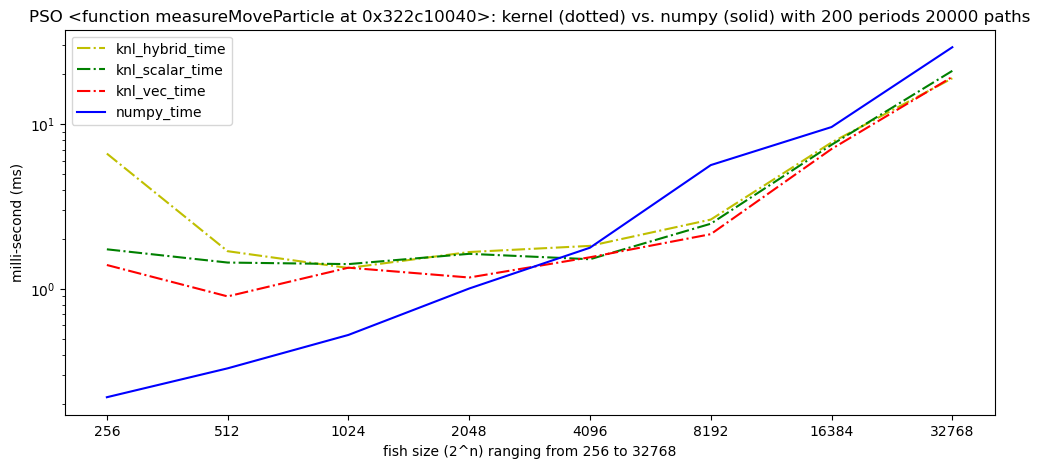

In [8]:
plotResults(min_exp, max_exp, step, S0, r, sigma, T, nPath, nPeriod, K, opttype, measureMoveParticle)

20000 paths, 200 periods.

exponent @ 8 with nFish set to 256
>>> hybrid GPU time: 1202.6955 ms
>>> scalar GPU time: 106.9232 ms
>>> vectorzied GPU time: 43.4495 ms
>>> numpy CPU time: 815.2259 ms
exponent @ 9 with nFish set to 512
>>> hybrid GPU time: 997.8381 ms
>>> scalar GPU time: 107.3846 ms
>>> vectorzied GPU time: 46.436 ms
>>> numpy CPU time: 1668.6397 ms
exponent @ 10 with nFish set to 1024
>>> hybrid GPU time: 995.4747 ms
>>> scalar GPU time: 102.8003 ms
>>> vectorzied GPU time: 42.7533 ms
>>> numpy CPU time: 4336.2678 ms
exponent @ 11 with nFish set to 2048
>>> hybrid GPU time: 996.9293 ms
>>> scalar GPU time: 103.0608 ms
>>> vectorzied GPU time: 43.0579 ms
>>> numpy CPU time: 8649.5704 ms
exponent @ 12 with nFish set to 4096
>>> hybrid GPU time: 1065.3967 ms
>>> scalar GPU time: 101.5985 ms
>>> vectorzied GPU time: 43.1959 ms
>>> numpy CPU time: 17830.0715 ms
exponent @ 13 with nFish set to 8192
>>> hybrid GPU time: 1152.5733 ms
>>> scalar GPU time: 106.0991 ms
>>> vectorzi

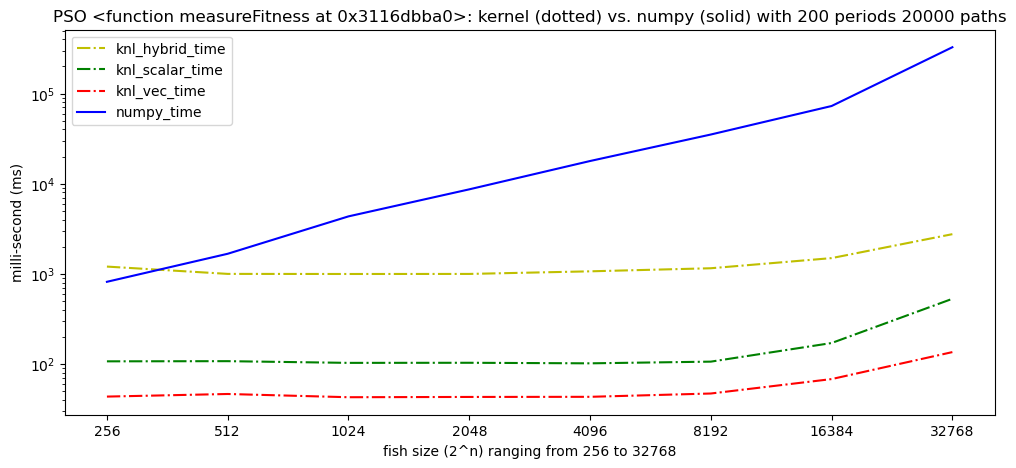

In [9]:
plotResults(min_exp, max_exp, step, S0, r, sigma, T, nPath, nPeriod, K, opttype, measureFitness)